Open ratio (0): 0.62
Sensors: [[0 0]
 [0 9]
 [9 0]
 [9 9]]
True Position: [1.5 1.5]
True Signals: [0.33333333 0.1        0.1        0.05263158]
Training data size: 558
Estimated Position: [2.64471759 2.62183974]
Error (Euclidean distance): 1.6027796990905978


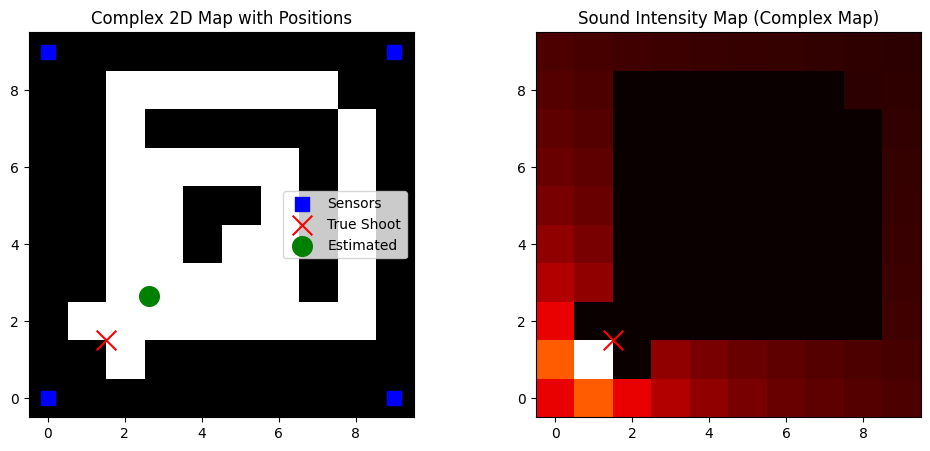

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import deque

# 더 복잡한 2D 맵 (0: 열린 공간, 1: 벽) - 미로 스타일 방/복도
map_size = 10
game_map = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 1, 1, 0, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
print("Open ratio (0):", np.sum(game_map == 0) / (map_size * map_size))

# 센서 위치 (모서리)
sensors = np.array([[0, 0], [0, map_size-1], [map_size-1, 0], [map_size-1, map_size-1]])
print("Sensors:", sensors)

# BFS로 벽 고려 최단 거리
def manhattan_dist_with_walls(start, end, game_map):
    rows, cols = game_map.shape
    start = (int(start[0]), int(start[1]))
    end = (int(end[0]), int(end[1]))
    if game_map[start[0], start[1]] == 1 or game_map[end[0], end[1]] == 1:
        return float('inf')
    queue = deque([start])
    visited = np.zeros((rows, cols), dtype=bool)
    visited[start] = True
    dist_map = np.full((rows, cols), float('inf'))
    dist_map[start] = 0
    
    dirs = [(0,1), (1,0), (0,-1), (-1,0)]
    while queue:
        r, c = queue.popleft()
        if (r, c) == end:
            return dist_map[r, c]
        for dr, dc in dirs:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and game_map[nr, nc] == 0 and not visited[nr, nc]:
                visited[nr, nc] = True
                dist_map[nr, nc] = dist_map[r, c] + 1
                queue.append((nr, nc))
    return float('inf')

# 소리 신호 생성
def generate_sound_signals(pos, sensors, game_map):
    signals = np.zeros(len(sensors))
    for i, sensor in enumerate(sensors):
        dist = manhattan_dist_with_walls(pos, sensor, game_map)
        signals[i] = 1 / (dist + 1) if dist < float('inf') else 0
    return signals

# 참 사격 위치 (복잡한 맵에서 열린 공간 선택)
true_shoot_pos = np.array([1.5, 1.5])  # 모서리 열린 공간 근처
true_signals = generate_sound_signals(true_shoot_pos, sensors, game_map)
print("True Position:", true_shoot_pos)
print("True Signals:", true_signals)

# 학습 데이터 생성 (열린 공간에서 1000개)
np.random.seed(42)
positions = []
signals_list = []
for _ in range(1000):
    rand_pos = np.random.uniform(0, map_size-1, 2)
    r, c = int(rand_pos[0]), int(rand_pos[1])
    if game_map[r, c] == 0:
        positions.append(rand_pos)
        signals_list.append(generate_sound_signals(rand_pos, sensors, game_map))

positions = np.array(positions)
signals_list = np.array(signals_list)
print("Training data size:", len(positions))

# 선형 회귀 (최소제곱법)
model_x = LinearRegression().fit(signals_list, positions[:, 0])
model_y = LinearRegression().fit(signals_list, positions[:, 1])

# 예측
est_pos_x = model_x.predict(true_signals.reshape(1, -1))[0]
est_pos_y = model_y.predict(true_signals.reshape(1, -1))[0]
est_pos = np.array([est_pos_x, est_pos_y])
error = np.linalg.norm(true_shoot_pos - est_pos)

# 결과 출력
print("Estimated Position:", est_pos)
print("Error (Euclidean distance):", error)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray', origin='lower')
ax[0].scatter(sensors[:, 1], sensors[:, 0], c='blue', marker='s', s=100, label='Sensors')
ax[0].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200, label='True Shoot')
ax[0].scatter(est_pos[1], est_pos[0], c='green', marker='o', s=200, label='Estimated')
ax[0].legend()
ax[0].set_title('Complex 2D Map with Positions')

# 소리 강도 맵
sound_map = np.zeros((map_size, map_size))
for i in range(map_size):
    for j in range(map_size):
        if game_map[i, j] == 0:
            dist = manhattan_dist_with_walls(true_shoot_pos, np.array([i, j]), game_map)
            sound_map[i, j] = 1 / (dist + 1) if dist < float('inf') else 0
ax[1].imshow(sound_map, cmap='hot', origin='lower')
ax[1].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200)
ax[1].set_title('Sound Intensity Map (Complex Map)')
plt.show()

Open ratio (0): 0.4925
Sensors: [[ 0  0]
 [ 0 19]
 [19  0]
 [19 19]]
True Position: [10.5 10.5]
True Signals: [0. 0. 0. 0.]
Training data size: 891
Estimated Position: [8.20205422 8.27628891]
Error (Euclidean distance): 3.197725100554512


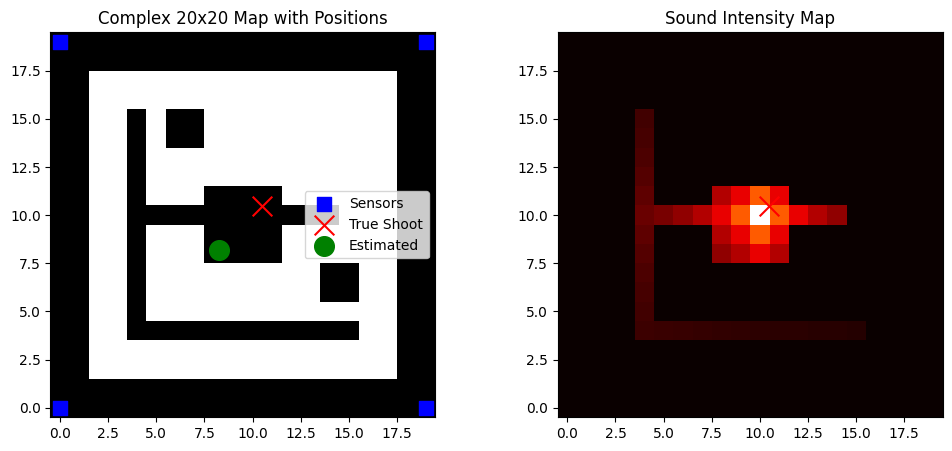

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import deque

# 더 크고 복잡한 2D 맵 (0: 열린 공간, 1: 벽) - 미로/다중 방
map_size = 20
game_map = np.ones((map_size, map_size))  # 기본적으로 벽
# 열린 공간 (복도, 방, 비대칭 구조)
game_map[0:2, :] = 0  # 상단 복도
game_map[18:20, :] = 0  # 하단 복도
game_map[:, 0:2] = 0  # 좌측 복도
game_map[:, 18:20] = 0  # 우측 복도
game_map[8:12, 8:12] = 0  # 중앙 방 (4x4)
game_map[4:16, 4] = 0  # 세로 통로
game_map[4, 4:16] = 0  # 가로 통로
game_map[6:8, 14:16] = 0  # 우상단 소규모 방
game_map[14:16, 6:8] = 0  # 좌하단 소규모 방
game_map[10, 5:15] = 0  # 중앙 가로 연결
# 불규칙 장애물
game_map[5:7, 7:9] = 1
game_map[13:15, 11:13] = 1
game_map[9, 2:4] = 1
print("Open ratio (0):", np.sum(game_map == 0) / (map_size * map_size))

# 센서 위치 (모서리)
sensors = np.array([[0, 0], [0, map_size-1], [map_size-1, 0], [map_size-1, map_size-1]])
print("Sensors:", sensors)

# BFS로 벽 고려 최단 거리
def manhattan_dist_with_walls(start, end, game_map):
    rows, cols = game_map.shape
    start = (int(start[0]), int(start[1]))
    end = (int(end[0]), int(end[1]))
    if game_map[start[0], start[1]] == 1 or game_map[end[0], end[1]] == 1:
        return float('inf')
    queue = deque([start])
    visited = np.zeros((rows, cols), dtype=bool)
    visited[start] = True
    dist_map = np.full((rows, cols), float('inf'))
    dist_map[start] = 0
    
    dirs = [(0,1), (1,0), (0,-1), (-1,0)]
    while queue:
        r, c = queue.popleft()
        if (r, c) == end:
            return dist_map[r, c]
        for dr, dc in dirs:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and game_map[nr, nc] == 0 and not visited[nr, nc]:
                visited[nr, nc] = True
                dist_map[nr, nc] = dist_map[r, c] + 1
                queue.append((nr, nc))
    return float('inf')

# 소리 신호 생성
def generate_sound_signals(pos, sensors, game_map):
    signals = np.zeros(len(sensors))
    for i, sensor in enumerate(sensors):
        dist = manhattan_dist_with_walls(pos, sensor, game_map)
        signals[i] = 1 / (dist + 1) if dist < float('inf') else 0
    return signals

# 참 사격 위치 (중앙 방 근처)
true_shoot_pos = np.array([10.5, 10.5])
true_signals = generate_sound_signals(true_shoot_pos, sensors, game_map)
print("True Position:", true_shoot_pos)
print("True Signals:", true_signals)

# 학습 데이터 생성 (열린 공간에서 2000개)
np.random.seed(42)
positions = []
signals_list = []
for _ in range(2000):
    rand_pos = np.random.uniform(0, map_size-1, 2)
    r, c = int(rand_pos[0]), int(rand_pos[1])
    if game_map[r, c] == 0:
        positions.append(rand_pos)
        signals_list.append(generate_sound_signals(rand_pos, sensors, game_map))

positions = np.array(positions)
signals_list = np.array(signals_list)
print("Training data size:", len(positions))

# 선형 회귀 (최소제곱법)
model_x = LinearRegression().fit(signals_list, positions[:, 0])
model_y = LinearRegression().fit(signals_list, positions[:, 1])

# 예측
est_pos_x = model_x.predict(true_signals.reshape(1, -1))[0]
est_pos_y = model_y.predict(true_signals.reshape(1, -1))[0]
est_pos = np.array([est_pos_x, est_pos_y])
error = np.linalg.norm(true_shoot_pos - est_pos)

# 결과 출력
print("Estimated Position:", est_pos)
print("Error (Euclidean distance):", error)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray', origin='lower')
ax[0].scatter(sensors[:, 1], sensors[:, 0], c='blue', marker='s', s=100, label='Sensors')
ax[0].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200, label='True Shoot')
ax[0].scatter(est_pos[1], est_pos[0], c='green', marker='o', s=200, label='Estimated')
ax[0].legend()
ax[0].set_title('Complex 20x20 Map with Positions')

# 소리 강도 맵
sound_map = np.zeros((map_size, map_size))
for i in range(map_size):
    for j in range(map_size):
        if game_map[i, j] == 0:
            dist = manhattan_dist_with_walls(true_shoot_pos, np.array([i, j]), game_map)
            sound_map[i, j] = 1 / (dist + 1) if dist < float('inf') else 0
ax[1].imshow(sound_map, cmap='hot', origin='lower')
ax[1].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200)
ax[1].set_title('Sound Intensity Map')
plt.show()

Open ratio (0): 0.4925
Sensors: [[ 0  0]
 [ 0 19]
 [19  0]
 [19 19]
 [ 5  5]
 [ 5 15]
 [15  5]
 [15 15]]
True Position: [10.5 10.5]
True Signals: [0. 0. 0. 0. 0. 0. 0. 0.]
Training data size: 891
Estimated Position: [8.20205422 8.27628891]
Error (Euclidean distance): 3.197725100554512


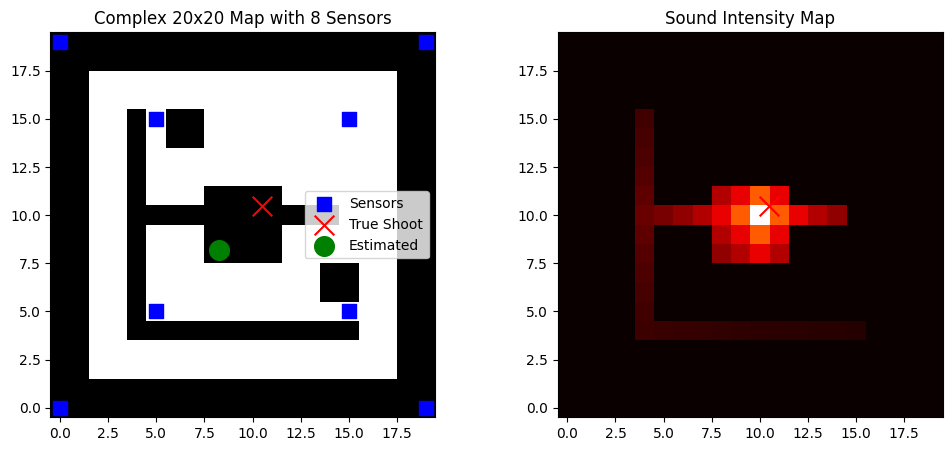

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import deque

# 복잡한 20x20 맵 (0: 열린 공간, 1: 벽)
map_size = 20
game_map = np.ones((map_size, map_size))
game_map[0:2, :] = 0  # 상단 복도
game_map[18:20, :] = 0  # 하단 복도
game_map[:, 0:2] = 0  # 좌측 복도
game_map[:, 18:20] = 0  # 우측 복도
game_map[8:12, 8:12] = 0  # 중앙 방 (4x4)
game_map[4:16, 4] = 0  # 세로 통로
game_map[4, 4:16] = 0  # 가로 통로
game_map[6:8, 14:16] = 0  # 우상단 방
game_map[14:16, 6:8] = 0  # 좌하단 방
game_map[10, 5:15] = 0  # 중앙 가로 연결
game_map[5:7, 7:9] = 1  # 장애물
game_map[13:15, 11:13] = 1
game_map[9, 2:4] = 1
print("Open ratio (0):", np.sum(game_map == 0) / (map_size * map_size))

# 센서 위치 (8개: 모서리 4 + 중앙/중간 4)
sensors = np.array([
    [0, 0], [0, map_size-1], [map_size-1, 0], [map_size-1, map_size-1],  # 모서리
    [5, 5], [5, 15], [15, 5], [15, 15]  # 추가 센서
])
print("Sensors:", sensors)

# BFS로 벽 고려 최단 거리
def manhattan_dist_with_walls(start, end, game_map):
    rows, cols = game_map.shape
    start = (int(start[0]), int(start[1]))
    end = (int(end[0]), int(end[1]))
    if game_map[start[0], start[1]] == 1 or game_map[end[0], end[1]] == 1:
        return float('inf')
    queue = deque([start])
    visited = np.zeros((rows, cols), dtype=bool)
    visited[start] = True
    dist_map = np.full((rows, cols), float('inf'))
    dist_map[start] = 0
    
    dirs = [(0,1), (1,0), (0,-1), (-1,0)]
    while queue:
        r, c = queue.popleft()
        if (r, c) == end:
            return dist_map[r, c]
        for dr, dc in dirs:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and game_map[nr, nc] == 0 and not visited[nr, nc]:
                visited[nr, nc] = True
                dist_map[nr, nc] = dist_map[r, c] + 1
                queue.append((nr, nc))
    return float('inf')

# 소리 신호 생성
def generate_sound_signals(pos, sensors, game_map):
    signals = np.zeros(len(sensors))
    for i, sensor in enumerate(sensors):
        dist = manhattan_dist_with_walls(pos, sensor, game_map)
        signals[i] = 1 / (dist + 1) if dist < float('inf') else 0
    return signals

# 참 사격 위치 (중앙 방 근처)
true_shoot_pos = np.array([10.5, 10.5])
true_signals = generate_sound_signals(true_shoot_pos, sensors, game_map)
print("True Position:", true_shoot_pos)
print("True Signals:", true_signals)

# 학습 데이터 생성 (열린 공간에서 2000개)
np.random.seed(42)
positions = []
signals_list = []
for _ in range(2000):
    rand_pos = np.random.uniform(0, map_size-1, 2)
    r, c = int(rand_pos[0]), int(rand_pos[1])
    if game_map[r, c] == 0:
        positions.append(rand_pos)
        signals_list.append(generate_sound_signals(rand_pos, sensors, game_map))

positions = np.array(positions)
signals_list = np.array(signals_list)
print("Training data size:", len(positions))

# 선형 회귀 (최소제곱법)
model_x = LinearRegression().fit(signals_list, positions[:, 0])
model_y = LinearRegression().fit(signals_list, positions[:, 1])

# 예측
est_pos_x = model_x.predict(true_signals.reshape(1, -1))[0]
est_pos_y = model_y.predict(true_signals.reshape(1, -1))[0]
est_pos = np.array([est_pos_x, est_pos_y])
error = np.linalg.norm(true_shoot_pos - est_pos)

# 결과 출력
print("Estimated Position:", est_pos)
print("Error (Euclidean distance):", error)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray', origin='lower')
ax[0].scatter(sensors[:, 1], sensors[:, 0], c='blue', marker='s', s=100, label='Sensors')
ax[0].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200, label='True Shoot')
ax[0].scatter(est_pos[1], est_pos[0], c='green', marker='o', s=200, label='Estimated')
ax[0].legend()
ax[0].set_title('Complex 20x20 Map with 8 Sensors')

# 소리 강도 맵
sound_map = np.zeros((map_size, map_size))
for i in range(map_size):
    for j in range(map_size):
        if game_map[i, j] == 0:
            dist = manhattan_dist_with_walls(true_shoot_pos, np.array([i, j]), game_map)
            sound_map[i, j] = 1 / (dist + 1) if dist < float('inf') else 0
ax[1].imshow(sound_map, cmap='hot', origin='lower')
ax[1].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200)
ax[1].set_title('Sound Intensity Map')
plt.show()

Open ratio (0): 0.4925
Sensors: [[ 0  0]
 [ 0 19]
 [19  0]
 [19 19]
 [ 5  5]
 [ 5 15]
 [15  5]
 [15 15]]
True Position: [10.5 10.5]
True Signals: [0. 0. 0. 0. 0. 0. 0. 0.]
Training data size: 891
Estimated Position: [8.08447015 8.22105099]
Error (Euclidean distance): 3.3209024412221453


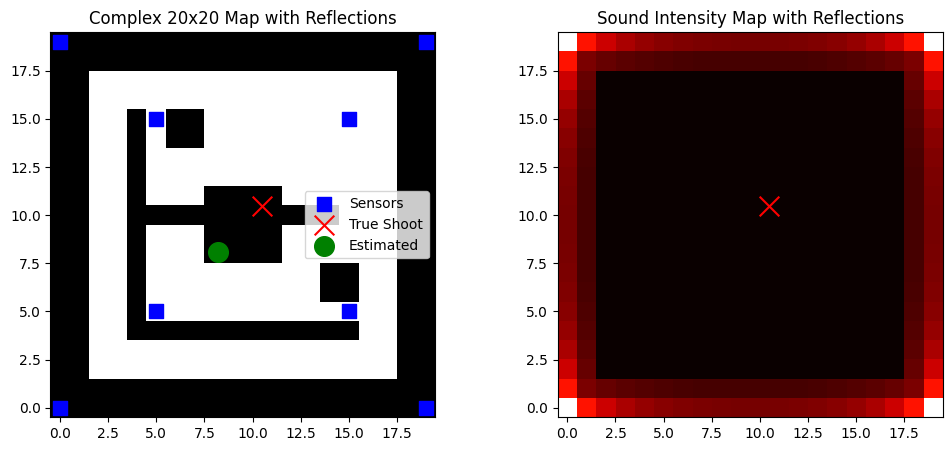

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import deque

# 복잡한 20x20 맵 (0: 열린 공간, 1: 벽)
map_size = 20
game_map = np.ones((map_size, map_size))
game_map[0:2, :] = 0
game_map[18:20, :] = 0
game_map[:, 0:2] = 0
game_map[:, 18:20] = 0
game_map[8:12, 8:12] = 0
game_map[4:16, 4] = 0
game_map[4, 4:16] = 0
game_map[6:8, 14:16] = 0
game_map[14:16, 6:8] = 0
game_map[10, 5:15] = 0
game_map[5:7, 7:9] = 1
game_map[13:15, 11:13] = 1
game_map[9, 2:4] = 1
print("Open ratio (0):", np.sum(game_map == 0) / (map_size * map_size))

# 센서 위치 (8개)
sensors = np.array([
    [0, 0], [0, map_size-1], [map_size-1, 0], [map_size-1, map_size-1],
    [5, 5], [5, 15], [15, 5], [15, 15]
])
print("Sensors:", sensors)

# BFS로 벽 고려 최단 거리
def manhattan_dist_with_walls(start, end, game_map):
    rows, cols = game_map.shape
    start = (int(start[0]), int(start[1]))
    end = (int(end[0]), int(end[1]))
    # 경계 체크
    if (start[0] < 0 or start[0] >= rows or start[1] < 0 or start[1] >= cols or
        end[0] < 0 or end[0] >= rows or end[1] < 0 or end[1] >= cols):
        return float('inf')
    if game_map[start[0], start[1]] == 1 or game_map[end[0], end[1]] == 1:
        return float('inf')
    queue = deque([start])
    visited = np.zeros((rows, cols), dtype=bool)
    visited[start] = True
    dist_map = np.full((rows, cols), float('inf'))
    dist_map[start] = 0
    
    dirs = [(0,1), (1,0), (0,-1), (-1,0)]
    while queue:
        r, c = queue.popleft()
        if (r, c) == end:
            return dist_map[r, c]
        for dr, dc in dirs:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and game_map[nr, nc] == 0 and not visited[nr, nc]:
                visited[nr, nc] = True
                dist_map[nr, nc] = dist_map[r, c] + 1
                queue.append((nr, nc))
    return float('inf')

# 반사 경로 계산
def reflection_path(pos, sensor, game_map):
    rows, cols = game_map.shape
    reflect_dists = []
    walls = [(0, 'x'), (cols-1, 'x'), (0, 'y'), (rows-1, 'y')]
    for wall in walls:
        wall_pos, axis = wall
        if axis == 'x':
            reflect_x = 2 * wall_pos - pos[0]
            reflect_point = np.array([reflect_x, pos[1]])
        else:
            reflect_y = 2 * wall_pos - pos[1]
            reflect_point = np.array([pos[0], reflect_y])
        # 경계 체크
        if (reflect_point[0] < 0 or reflect_point[0] >= rows or
            reflect_point[1] < 0 or reflect_point[1] >= cols):
            reflect_dists.append(float('inf'))
            continue
        dist1 = manhattan_dist_with_walls(pos, reflect_point, game_map)
        dist2 = manhattan_dist_with_walls(reflect_point, sensor, game_map)
        total_dist = dist1 + dist2 if dist1 < float('inf') and dist2 < float('inf') else float('inf')
        reflect_dists.append(total_dist)
    return reflect_dists

# 소리 신호 생성 (직접 + 반사)
def generate_sound_signals(pos, sensors, game_map):
    signals = np.zeros(len(sensors))
    alpha = 0.7  # 반사 감쇠 계수
    for i, sensor in enumerate(sensors):
        dist_direct = manhattan_dist_with_walls(pos, sensor, game_map)
        intensity_direct = 1 / (dist_direct + 1) if dist_direct < float('inf') else 0
        reflect_dists = reflection_path(pos, sensor, game_map)
        intensity_reflect = sum(alpha * 1 / (d + 1) for d in reflect_dists if d < float('inf'))
        signals[i] = intensity_direct + intensity_reflect
    return signals

# 참 사격 위치
true_shoot_pos = np.array([10.5, 10.5])
true_signals = generate_sound_signals(true_shoot_pos, sensors, game_map)
print("True Position:", true_shoot_pos)
print("True Signals:", true_signals)

# 학습 데이터 생성
np.random.seed(42)
positions = []
signals_list = []
for _ in range(2000):
    rand_pos = np.random.uniform(0, map_size-1, 2)
    r, c = int(rand_pos[0]), int(rand_pos[1])
    if game_map[r, c] == 0:
        positions.append(rand_pos)
        signals_list.append(generate_sound_signals(rand_pos, sensors, game_map))

positions = np.array(positions)
signals_list = np.array(signals_list)
print("Training data size:", len(positions))

# 선형 회귀
model_x = LinearRegression().fit(signals_list, positions[:, 0])
model_y = LinearRegression().fit(signals_list, positions[:, 1])

# 예측
est_pos_x = model_x.predict(true_signals.reshape(1, -1))[0]
est_pos_y = model_y.predict(true_signals.reshape(1, -1))[0]
est_pos = np.array([est_pos_x, est_pos_y])
error = np.linalg.norm(true_shoot_pos - est_pos)

# 결과 출력
print("Estimated Position:", est_pos)
print("Error (Euclidean distance):", error)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray', origin='lower')
ax[0].scatter(sensors[:, 1], sensors[:, 0], c='blue', marker='s', s=100, label='Sensors')
ax[0].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200, label='True Shoot')
ax[0].scatter(est_pos[1], est_pos[0], c='green', marker='o', s=200, label='Estimated')
ax[0].legend()
ax[0].set_title('Complex 20x20 Map with Reflections')

# 소리 강도 맵
sound_map = np.zeros((map_size, map_size))
for i in range(map_size):
    for j in range(map_size):
        if game_map[i, j] == 0:
            signals = generate_sound_signals(np.array([i, j]), sensors, game_map)
            sound_map[i, j] = np.sum(signals)
ax[1].imshow(sound_map, cmap='hot', origin='lower')
ax[1].scatter(true_shoot_pos[1], true_shoot_pos[0], c='red', marker='x', s=200)
ax[1].set_title('Sound Intensity Map with Reflections')
plt.show()